<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задание" data-toc-modified-id="Задание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задание</a></span></li><li><span><a href="#Загрузка-данных-и-функции" data-toc-modified-id="Загрузка-данных-и-функции-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных и функции</a></span></li><li><span><a href="#Обучение-модели-с-параметрами-p=3,-h-=-{1,-10}" data-toc-modified-id="Обучение-модели-с-параметрами-p=3,-h-=-{1,-10}-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели с параметрами p=3, h = {1, 10}</a></span></li><li><span><a href="#Теоретические-задания" data-toc-modified-id="Теоретические-задания-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Теоретические задания</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels as sm

warnings.filterwarnings('ignore')
%matplotlib inline

### Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

2. Оцените ошибку модели из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.




### Загрузка данных и функции

In [2]:
# 2.1. File Path
!ls ../data
file_path = '../data/'+os.listdir('../data')[1]
file_path

covid_19_data.csv
my_BRENT2019.csv
my_PJME_MW.csv


'../data/my_BRENT2019.csv'

In [3]:
# 2.2. Data Loading
df = pd.read_csv(file_path, encoding='utf-8', index_col=[0], parse_dates=[0])
#target = 'PJME_MW'
target = 'Значение'

df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [4]:
df.nunique()

Значение           2144
year                 10
month                12
dayofmonth           31
quarter               4
dayofyear           365
weekofyear           53
dayofweek             7
is_holiday            2
is_prev_holiday       2
is_next_holiday       2
dtype: int64

In [5]:
# 2.3. Пользовательские функции

# 2.3.1. Функция (внутренняя) для расчета экспоненциального сглаживания
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# 2.3.2. Функция для создания и визуализации датафрейма с исходным рядом и 
# экспоненциальным сглаживанием и расчетом остатков
def add_exp_ma(df, target, alpha, window_size, show_chart=False, n_items_for_chart=500):
    from statsmodels.tsa.stattools import adfuller
    
    df['exp'] = exponential_smoothing(df[target], alpha)
    target_ar_exp_1 = pd.DataFrame(data=df['exp'], index = df.index)
    res = (df[target] - target_ar_exp_1.iloc[:,0])
    adf_pvalue = adfuller(res, regression='ctt')[1]
    
    if show_chart:
        plt.figure(figsize=(18, 7))
        
        plt.plot(df.index[:n_items_for_chart], df[target][:n_items_for_chart], '.b', label='исходный ряд')
        
        plt.plot(df[target][:n_items_for_chart].rolling(window=window_size).mean(), label="скользящие средние")

        
        plt.plot(df.index[:n_items_for_chart], target_ar_exp_1[:n_items_for_chart], color = 'red', 
                 label="экспоненциальное сглаживание")
        
        plt.plot(df.index[:n_items_for_chart], res[:n_items_for_chart], 
                 color = 'green', label="без тренда по экспоненциальному сглаживанию")
        
        plt.title(f'daily sum of {target}. P-value on residuals: {adf_pvalue:.5f}')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('MW')
        
        plt.show()
        
        
    return df, res

# 2.4.3. функция, генерирующая датафрейм с историческими данными, экспоненциальным сглаживанием и 
# первой разностью исходного ряда
def create_df_history_variables(df, target='exp', p=3, add_exp_smooth=False, alphas=[0.05, 0.1]):
    df_new = pd.DataFrame(df[target])
    for i in range(1, p+1):
        col_name = f't{i}'
        df_new[col_name] = 0
        df_new.iloc[i:, i] = df_new.iloc[:-i,0].values
    df_new.fillna(0)
    
    df_new['diff1'] = 0
    df_new['diff1'].iloc[1:] = df_new.iloc[1:,0].values - df_new.iloc[:-1, 0].values
    
    if add_exp_smooth:
        for a in alphas:
            col_name = f'exp_0_{a}'
            df_new[col_name] = exponential_smoothing(df_new[target], a)
    
    return df_new

# 2.4.4. Функция (внутренняя)  для разделения датафрейма по заданной дате
def split_data(df, split_date):
    
    return df.loc[df.index.get_level_values('Дата') <= split_date].copy(), \
           df.loc[df.index.get_level_values('Дата') >  split_date].copy()

# 2.4.5. Функция (внутренняя) для определения даты по заданной пропорции разделения датафрейма
def define_split_date(df, test_portion):
    raw_date = df.iloc[:int(len(df)*(1 - test_portion))].iloc[-1].name
    y, m, d = raw_date.year, raw_date.month, raw_date.day
    return f'{y}-{m}-{d}'

# 2.4.6. Функция, возвращающая (X_train, X_test, y_train, y_test) по заданным параметрам test_portion и forecast_step 
def split_2_train_test(df, test_portion, h, show_chart=True):
    # 1. Определим дату отсечения
    split_date = define_split_date(df=df, test_portion=test_portion)
    # 2. Разрежем исходный датасет
    train, test = split_data(df=df, split_date=split_date)
    X_train = train.iloc[:-h, :]
    y_train = train[df.columns[0]].values[h:]
    X_test = test.iloc[:-h, :]
    y_test = test[df.columns[0]].values[h:]
    
    if show_chart:
        plt.figure( figsize=( 15, 7 ))
        plt.xlabel('Time')
        plt.ylabel(f'daily sum of {target}')
        plt.plot(train.index,train[df.columns[0]], label='train data' )
        plt.plot(test.index, test[df.columns[0]], label='test data')
        plt.title( 'Тестовые и тренировочные данные' )
        plt.legend()
        plt.show()
    
    return (X_train, y_train, X_test, y_test)

# 2.4.7. Функция (внутренняя) для расчета ошибки в процентах
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 2.4.8. Функция, вызывающая процесс train_test_split, обучающаяся и рассчитывающая метрику
def fit_and_predict(df, test_portion, h, model_instance, original_df, model_params=None, show_chart=True):
    
    X_train, y_train, X_test, y_test = split_2_train_test(df=df, test_portion=test_portion, h=h,
                                                         show_chart=False)
    split_date = define_split_date(df=df, test_portion=test_portion)
    train, test = split_data(df=df, split_date=split_date)
    
    try:
        if model_params:
            model = model_instance(**model_params)
        else:
            model = model_instance()
            
    except Exception:
        print('put correct MODEL instance')
        return None
    
    model.fit(X_train, y_train)
    X_test_pred = model.predict(X_test)
    metric = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)
    
    if show_chart:
        plt.figure( figsize=(18, 6))
        plt.xlabel('Time')
        plt.ylabel(f'daily summed {target}')
        plt.plot(test.index[h:],X_test_pred, label='predict data' )
        plt.plot(test.index[h:],y_test, label='test data')
        plt.plot(original_df.loc[split_date:].index, original_df.loc[split_date:][target], label='исходный ряд')
        plt.title(f'error on forecast: {metric:.3f}%')
        plt.legend()
        plt.show()
    
    return model, X_test_pred, metric
        

### Обучение модели с параметрами p=3, h = {1, 10}

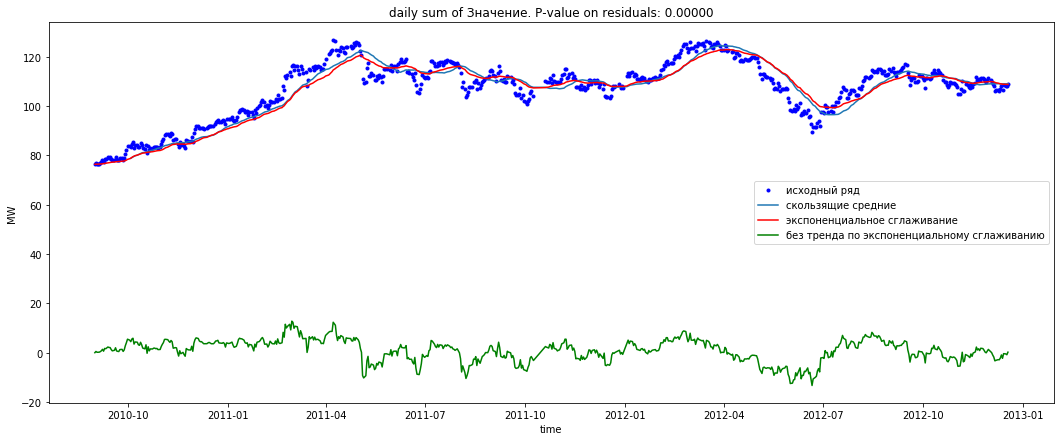

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,exp
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,76.370000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,76.396000
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,76.404700
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,76.415465
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,76.426192


In [6]:
# 3.1. Сгенерируем экспоненциальное сглаживание с alpha=0.05
d_data_exp, residuals = add_exp_ma(df, target, alpha=0.05, window_size=30, show_chart=True, n_items_for_chart=700)

d_data_exp.head()

Остатки (разница основного и сглаженного рядов) - имеют схожесть с белым шумом, что подтверждается ADF-тестом на стационарность.

In [7]:
# 3.2. Сгенерируем датафрейм с историческими данными
df_4_analysis = create_df_history_variables(df, add_exp_smooth=True, p=3, alphas=[0.05, 0.08])
df_4_analysis.head()

,exp,t1,t2,t3,diff1,exp_0_0.05,exp_0_0.08
Дата,,,,,,,
2010-09-01,76.370000,0.000000,0.0000,0.000,0.000000,76.370000,76.370000
2010-09-02,76.396000,76.370000,0.0000,0.000,0.026000,76.371300,76.372080
2010-09-03,76.404700,76.396000,76.3700,0.000,0.008700,76.372970,76.374690
2010-09-04,76.415465,76.404700,76.3960,76.370,0.010765,76.375095,76.377952
2010-09-05,76.426192,76.415465,76.4047,76.396,0.010727,76.377650,76.381811


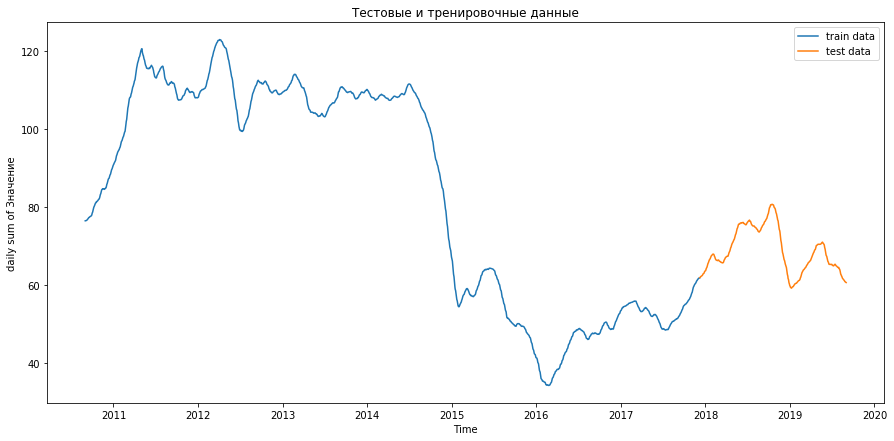

split date: 2017-12-7


In [8]:
# 3.3. Визуализируем разделение на train и test с пропорциями 80/20
X_train, y_train, X_test, y_test = split_2_train_test(df_4_analysis, test_portion=0.2, h=1, show_chart=True)
split_date = define_split_date(df_4_analysis, test_portion=0.2)
print(f'split date: {split_date}')

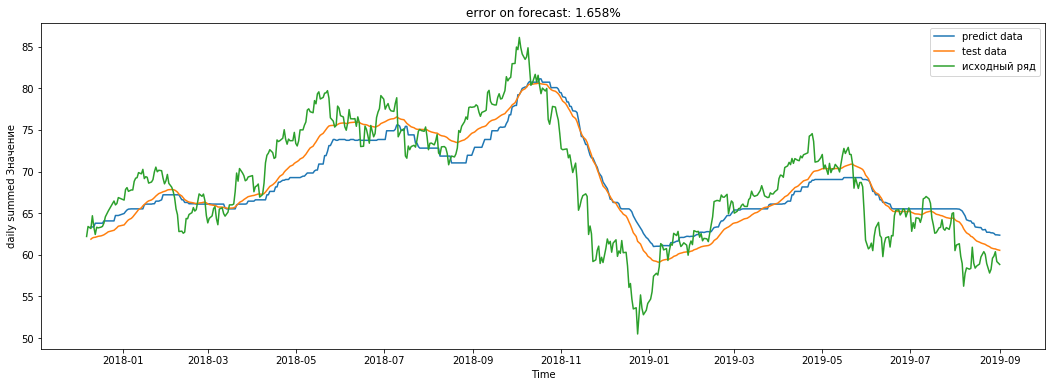

In [22]:
# 3.4. Оценка с 1-step forecast (h=1)
from sklearn.ensemble import GradientBoostingRegressor

model_instance = GradientBoostingRegressor

model_params = {'max_depth':5, 
                'random_state':42, 
                'n_estimators':25,
                'learning_rate': 0.1}
                
model_h1, y_predict_h1, metric_h1 = fit_and_predict(df=df_4_analysis, test_portion=0.2, h=1, 
                                                    model_instance=model_instance, original_df=d_data_exp, 
                                                    model_params=model_params, show_chart=True)

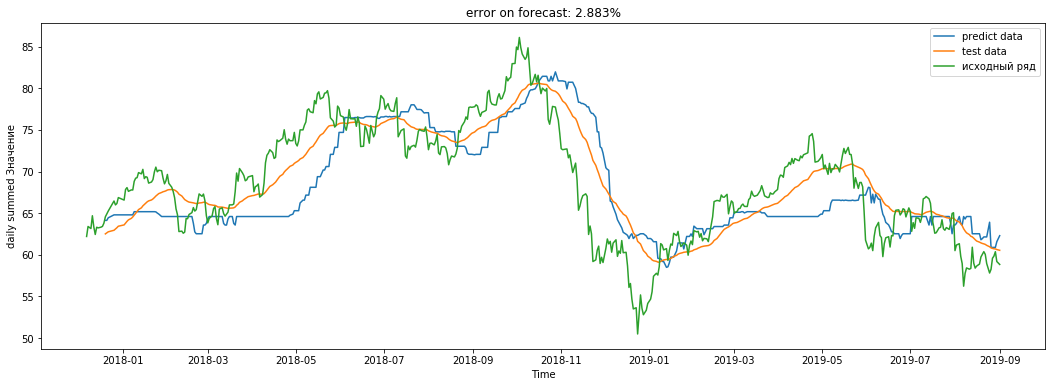

In [23]:
# 3.5. Оценка с 10-step forecast (h=10)

model_h10, y_predict_h10, metric_h10 = fit_and_predict(df=df_4_analysis, test_portion=0.2, h=10, 
                                                    model_instance=model_instance, original_df=d_data_exp, 
                                                    model_params=model_params, show_chart=True)

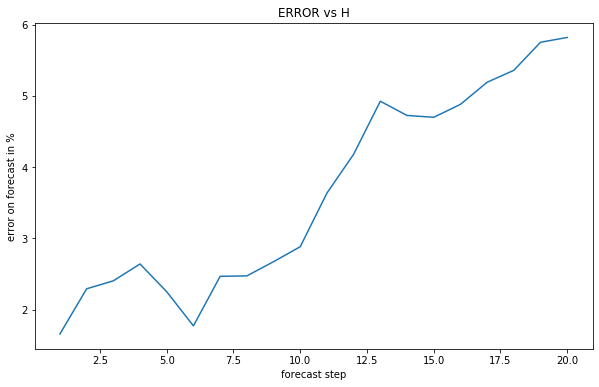

In [26]:
# 3.6. Зависимость метрики от h
h_range = range(1,21)
metric_range = []

for h in h_range:
    model, y_predict, metric = fit_and_predict(df=df_4_analysis, test_portion=0.2, h=h, 
                                               model_instance=model_instance, original_df=d_data_exp, 
                                               model_params=model_params, show_chart=False)
    metric_range.append(metric)
    
plt.figure(figsize=(10,6))
plt.plot(h_range, metric_range)
plt.xlabel('forecast step')
plt.ylabel('error on forecast in %')
plt.title('ERROR vs H')
plt.show()

Выводы:
- модель генерирует прогноз с ошибками на уровне от 2 до 6% (рассчитанных на основе сглаженного варианта рядов)
- при этом увеличение длины прогноза увеличивает размер ошибки

### Теоретические задания

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

   - а) Изменение температуры за окном :).

   - б) Количество денег, которые тратят покупатели в интернет магазине.

   - в) Вес растущего котенка.

   - г) Прирост объема деревьев в лесу от времени

Ответы:
- (а) изменение температуры за окном (временной ряд в виде дельты):
  - если временной отрезок - небольшой (например, 1 час) - то изменения будут иметь сезонность по времени дня (вечер и утро - дельта <> 0, день и ночь - дельта = 0, в целом такой ряд скорее будет стационарным
  
- (б) количество денег, которые тратят покупатели в интернет-магазине:
  - ряд будет с трендом (например вследствие инфляционного влияния, если временной горизонт ряда - достаточно большой), с сезонностью, связанной с праздниками и типами товаров магазина, также может содержать циклы, связанные с цикличностью товаров и экономическими циклами
    
- (в) вес растущего котенка - это явно нестационарный ряд с трендом типа логарифмической кривой, сезонности можно выделить, если измерять вес в очень коротких промежутках времени (1 час)

- (г) прирост объема деревьев в лесу от времени: если под объемом деревьев понимается их количество, то такой ряд будет иметь сезонность
